In [108]:
import numpy as np
from sklearn.datasets import fetch_20newsgroups
from sklearn import decomposition
from scipy import linalg
import matplotlib.pyplot as plt

%matplotlib inline
np.set_printoptions(suppress=True)

In [109]:
# just another dataset 

# categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
# remove = ('headers', 'footers', 'quotes')
# newsgroups_train = fetch_20newsgroups(subset='train', categories=categories, remove=remove)
# newsgroups_test = fetch_20newsgroups(subset='test', categories=categories, remove=remove)

# newsgroups_train.filenames.shape, newsgroups_train.target.shape

In [110]:
# download this dataset from http://mlg.ucd.ie/datasets/bbc.html
texts = [open(f"bbc/tech/{'%03d' % i}.txt", "r").read() for i in range(1, 402)]

In [155]:
texts[103]

'Games \'deserve a place in class\'\n\nComputer games could enhance learning and have a legitimate place in the classroom, say researchers.\n\nAcademics from the Institute of Education at London University found that "games literacy" was a key skill for youngsters. As well as being used in different areas of the curriculum, games are a legitimate area of study in their own right, researchers say. Pupils should also be able to create their own games, they say.\n\n"Like all games, computer and video games entertain while promoting social development, and playing and talking about games is an important part of young people\'s lives," said project manager Caroline Pelletier.\n\n"Games literacy is a way of investigating how games are means of expression and representation, just like writing or drawing," she said. The researchers conducted two studies into the impact of games on education, the first looking at how they can be used in different curriculum subjects to enhance learning. Researc

In [111]:
from sklearn.feature_extraction import stop_words

In [10]:
import nltk
from nltk import stem
from nltk import word_tokenize, stem, punkt

In [398]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /Users/tama-ts/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/tama-ts/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/tama-ts/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

We now need to preprocess our texts and transform them into vectors. We use the following preprocessing steps:
- tokenization: split all the texts into words, lowercase them and remove punctuation
- removing stop words
- lemmatization: conforming different forms of the same word


In [399]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk import word_tokenize, stem, punkt
from nltk.tag import pos_tag
import re

class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = stem.WordNetLemmatizer()
    def __call__(self, doc):
        SYMBOLS_TO_KEEP = re.compile('[^A-Za-z0-9]+')
        doc = re.sub(SYMBOLS_TO_KEEP," ",doc)
        return [self.wnl.lemmatize(t[0]) for t in pos_tag(word_tokenize(doc)) if (len(t[0]) >3) 
                                                                            & (t[0] not in stop_words.ENGLISH_STOP_WORDS)
                                                                            & (t[1][0] == 'N')]

vectorizer = CountVectorizer(tokenizer=LemmaTokenizer(),
                            lowercase=True,  
                            max_df = 0.9,
                            min_df =5)

# We could have used TfidfVectorizer() instead

vectors = vectorizer.fit_transform(texts).todense()
vectors.shape
words = vectorizer.get_feature_names()
vectors_indicator = np.where(vectors>0, 1, 0)

In [400]:
# computing word by word matrix: its values yield the number of texts in which two words occur together
w_by_w = vectors_indicator[:300].T @ vectors_indicator[:300]
# np.fill_diagonal(w_by_w, 0)
test_texts_vec = vectors_indicator[300:]

In [401]:
w_by_w.shape #matrix words by words

(1305, 1305)

In [402]:
len(words) #a list of words that correspond to columns

1305

In [403]:
# here we normalize rows, in order to consider relative frequencies and not absolute
from sklearn.preprocessing import normalize
x_n = normalize(w_by_w, axis=0, norm='l2')

In [404]:
U, S, Vt = np.linalg.svd(x_n, full_matrices=False)

(0, 100)

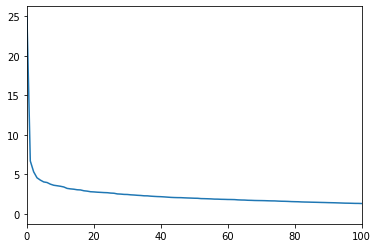

In [405]:
plt.plot(S)
plt.xlim([0,100])

In [406]:
U[:, 1]

array([ 0.03675364,  0.00500442, -0.07428547, ..., -0.02317186,
        0.0012982 , -0.00568935])

In [407]:
# this funstion returns the words that correspond to maximal values in each row of the input matrix
num_top_words=8

def show_topics(a):
    top_words = lambda t: [words[i] for i in np.argsort(t)[:-num_top_words-1:-1]]
    topic_words = ([top_words(t) for t in a])
    return [' '.join(t) for t in topic_words]

# print(words[50:60])
# show_topics(Vt[50:60])

In [408]:
new_dim = 15
U_new = U[:, :new_dim] @ np.diag(S[:new_dim])# the rows of this matrix are coordinates of the words in a new orthogonal bsis of the columns of Vt of Vt

In [409]:
show_topics(w_by_w[:10])

['ability people year website technology market game number',
 'academic year research world computer science power engineering',
 'access people service year technology user time number',
 'account people firm year website month news company',
 'people acquisition information user software browser program computer',
 'action people year time company website game technology',
 'activity people time year research computer technology device',
 'adapter market device music game player world development',
 'addition time world medium number company people customer',
 'address people firm message service mail user website']

### Clustering

In [524]:
from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation, SpectralClustering, DBSCAN, MeanShift, OPTICS, Birch
import scipy.cluster.hierarchy as sch

#### KMeans

In [410]:
clustering_kmeans = KMeans(n_clusters=50).fit(U_new)

In [411]:
clustering_kmeans.cluster_centers_

array([[-0.25771158, -0.14948876,  0.02121914,  0.0977998 , -0.00441957,
        -0.0148276 , -0.05120083,  0.07871016, -0.02581244,  0.03889081,
         0.01957987, -0.03651647, -0.02741986,  0.00095785,  0.03903911],
       [-2.17366822,  0.47404025, -0.5197272 , -0.00376419, -0.04708638,
        -0.1290743 , -0.06585079,  0.05292219, -0.14918838, -0.22120435,
        -0.09375193, -0.09293848, -0.05861827,  0.01591597, -0.15510282],
       [-2.34847947, -0.61450434,  0.28052443, -0.21032487,  0.13194978,
         0.17127924, -0.34152704, -0.00195653,  0.04740558, -0.11913447,
        -0.10709137, -0.16651087,  0.02517057,  0.12534484,  0.22091592],
       [-0.51209576,  0.14216712, -0.159268  ,  0.00355901,  0.00648261,
        -0.08964396, -0.05662358,  0.00754231,  0.04686656, -0.01896691,
         0.04391354, -0.01616984, -0.05427256, -0.01486485, -0.01395929],
       [-1.49088745,  0.32531354, -0.32269962, -0.0173556 ,  0.04002351,
        -0.19776562, -0.17657286, -0.01644604, 

In [412]:
y_kmeans = clustering_kmeans.predict(U_new)

In [413]:
y_kmeans

array([30, 12, 16, ...,  0, 44, 42], dtype=int32)

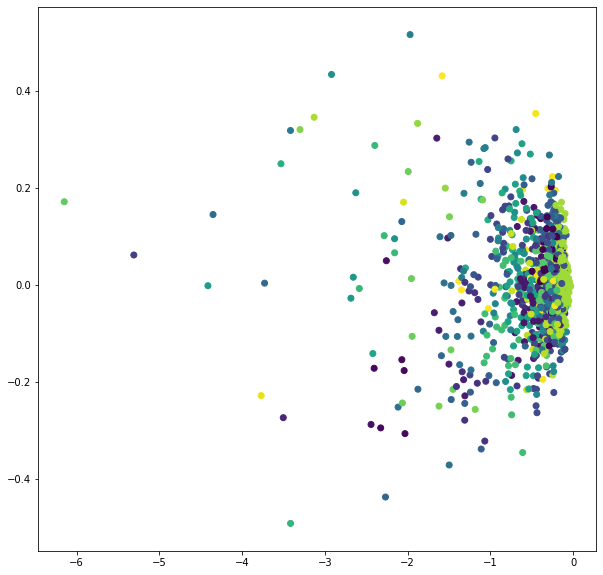

In [414]:
plt.figure(figsize=(10,10))
plt.scatter(U_new[:, 0], U_new[:, 9], c=y_kmeans)

#### Hierarchical Clustering 

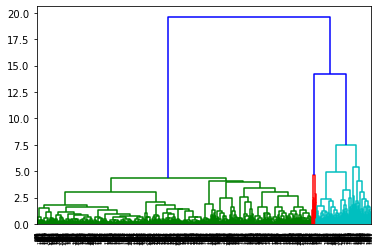

In [415]:
dendrogram = sch.dendrogram(sch.linkage(U_new, method='ward'))# create clusters
clustering_hc = AgglomerativeClustering(n_clusters=50, affinity = 'euclidean', linkage = 'ward')# save clusters for chart
y_hc = clustering_hc.fit_predict(U_new)

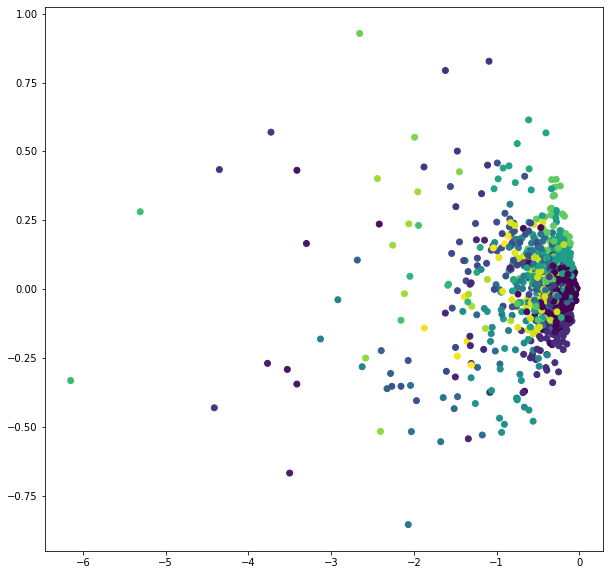

In [416]:
plt.figure(figsize=(10,10))
plt.scatter(U_new[:, 0], U_new[:, 2], c=y_hc)

https://scikit-learn.org/stable/modules/clustering.html

Document Clustering Based On Non-negative MatrixFactorization

#### Affinity Propagation

In [417]:
clustering_aff = AffinityPropagation().fit(U_new)
y_aff = clustering_aff.predict(U_new)

In [418]:
clustering_aff.cluster_centers_.shape

(200, 15)

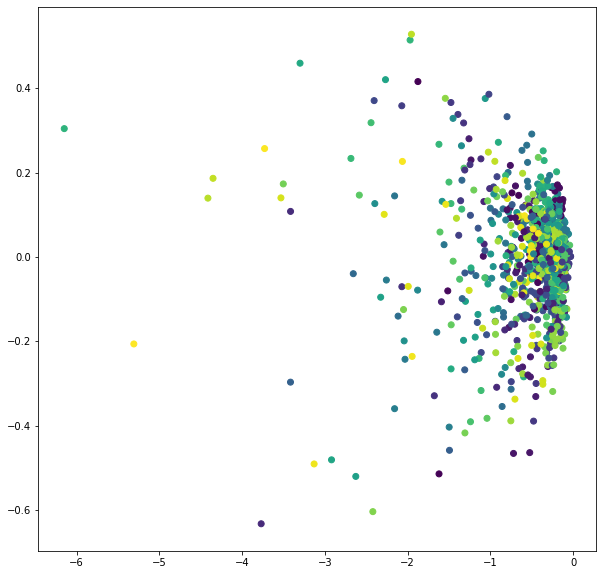

In [549]:
plt.figure(figsize=(10,10))
plt.scatter(U_new[:, 0], U_new[:, 4], c=y_aff)

#### Spectral Clustering

In [419]:
clustering_spectral = SpectralClustering(n_clusters=50,assign_labels="discretize").fit(U_new)

In [420]:
clustering_spectral.labels_

array([48,  1, 25, ...,  1, 41,  1])

In [421]:
clustering_spectral.get_params()

{'affinity': 'rbf',
 'assign_labels': 'discretize',
 'coef0': 1,
 'degree': 3,
 'eigen_solver': None,
 'eigen_tol': 0.0,
 'gamma': 1.0,
 'kernel_params': None,
 'n_clusters': 50,
 'n_init': 10,
 'n_jobs': None,
 'n_neighbors': 10,
 'random_state': None}

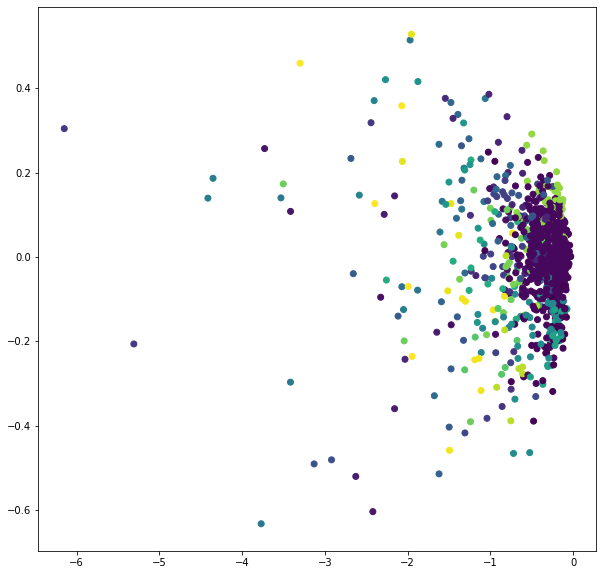

In [550]:
plt.figure(figsize=(10,10))
plt.scatter(U_new[:, 0], U_new[:, 4], c=clustering_spectral.labels_)

#### DBSCAN

In [454]:
clustering_DBSCAN = DBSCAN(eps=0.01, min_samples=2).fit(U_new)

In [455]:
y_DBSCAN = clustering_DBSCAN.fit_predict(U_new)

In [478]:
y_DBSCAN

array([-1, -1, -1, ..., -1, -1, -1])

In [475]:
clustering_DBSCAN.get_params()

{'algorithm': 'auto',
 'eps': 0.01,
 'leaf_size': 30,
 'metric': 'euclidean',
 'metric_params': None,
 'min_samples': 2,
 'n_jobs': None,
 'p': None}

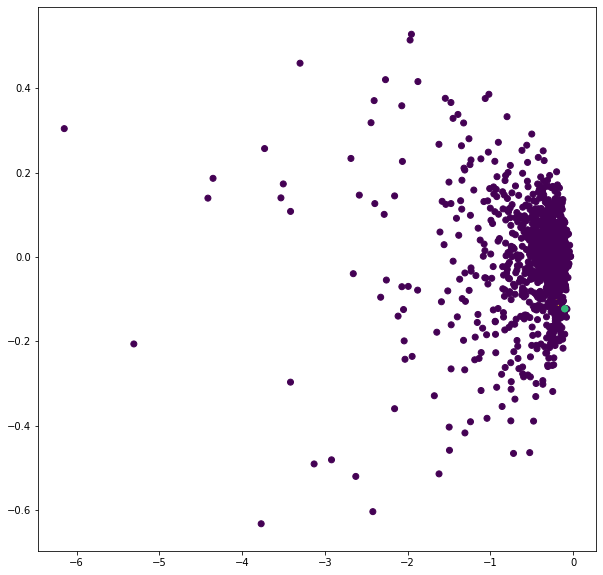

In [552]:
plt.figure(figsize=(10,10))
plt.scatter(U_new[:, 0], U_new[:, 4], c=y_DBSCAN)

#### MeanShift

In [497]:
clustering_MS = MeanShift().fit(U_new)

In [498]:
y_MS = clustering_MS.predict(U_new)

In [522]:
clustering_MS.cluster_centers_.shape[0]

108

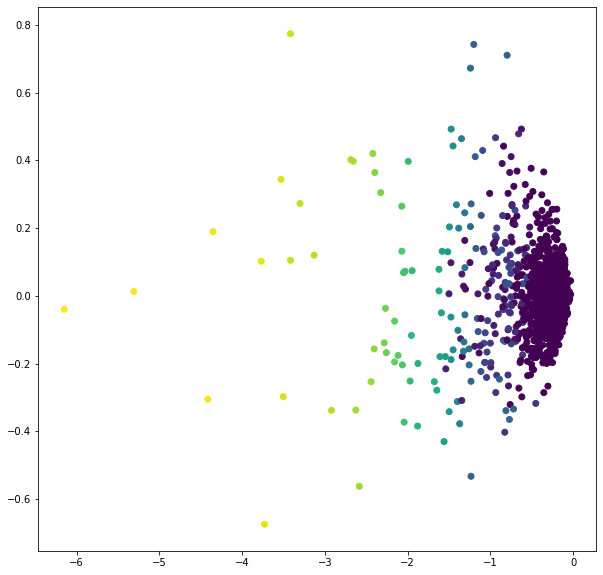

In [547]:
plt.figure(figsize=(10,10))
plt.scatter(U_new[:, 0], U_new[:, 3], c=y_MS)

#### OPTICS

In [426]:
clustering_OPT = OPTICS(min_samples=2).fit(U_new)

/Users/tama-ts/anaconda3/lib/python3.7/site-packages/sklearn/cluster/optics_.py:791: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


In [482]:
y_opt = OPTICS(min_samples=2).fit_predict(U_new)

/Users/tama-ts/anaconda3/lib/python3.7/site-packages/sklearn/cluster/optics_.py:791: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


In [486]:
len(np.unique(y_opt))

193

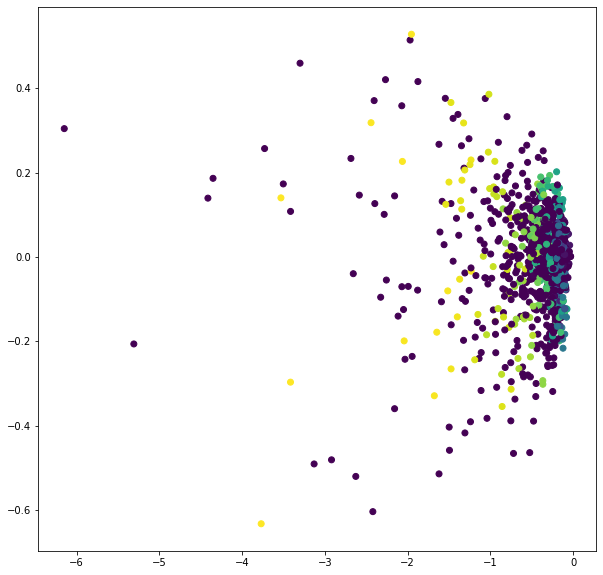

In [553]:
plt.figure(figsize=(10,10))
plt.scatter(U_new[:, 0], U_new[:, 4], c=y_opt)

#### Birch

In [526]:
brc = Birch(n_clusters=120)

In [527]:
brc.fit(U_new)

/Users/tama-ts/anaconda3/lib/python3.7/site-packages/sklearn/cluster/birch.py:627: ConvergenceWarning: Number of subclusters found (78) by Birch is less than (120). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)


Birch(branching_factor=50, compute_labels=True, copy=True, n_clusters=120,
      threshold=0.5)

In [528]:
y_birch = brc.predict(U_new)

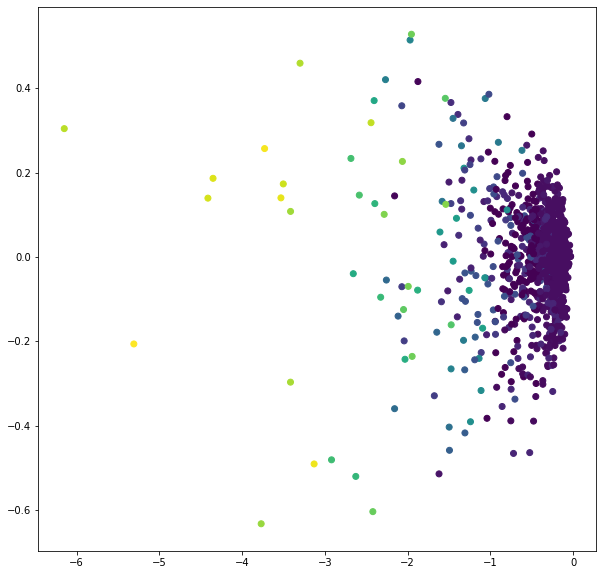

In [554]:
plt.figure(figsize=(10,10))
plt.scatter(U_new[:, 0], U_new[:, 4], c=y_birch)

We tried different clustering methods. Some of them did well (like Birch), some of them didn't manage to distinguish data at all. Then we started selecting clustering models for testing. But soon we realized that not all of tjem provide cluster centers (like OPTICS that we counted much on) or set the cluster's centroid a medium point (like KMeans). As for our tagging we decided to use clusters centers, that didn't suit us at all. That's why we decided to concentrate on 3 following clustering methods. We also use cv-tuned KNN to predict closest clusters centers to define tags.

#### Affinity Propagation

In [428]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)

In [461]:
from sklearn.model_selection import GridSearchCV

params = {'n_neighbors':[5,6,7,8,9,10],
          'leaf_size':[1,2,3,5],
          'algorithm':['auto', 'ball_tree','kd_tree','brute']}
knn_cv_aff = GridSearchCV(knn, param_grid=params, n_jobs=1)

In [462]:
knn_cv_aff.fit(U_new, y_aff)

/Users/tama-ts/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/tama-ts/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
/Users/tama-ts/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=1,
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'leaf_size': [1, 2, 3, 5],
                         'n_neighbors': [5, 6, 7, 8, 9, 10]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [463]:
knn_cv_aff.best_params_

{'algorithm': 'auto', 'leaf_size': 1, 'n_neighbors': 5}

In [464]:
knn_cv_aff.best_estimator_

KNeighborsClassifier(algorithm='auto', leaf_size=1, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [509]:
#here we want to access the results
#pick a random text from test poll and calculate it's projection on Vt basis
def print_tag_aff(n):
    text_proj = (Vt[:new_dim] @test_texts_vec[n]).reshape(1,-1)
    centroid = knn_cv_aff.best_estimator_.predict_proba(text_proj)[0]
    ss_ind = np.argsort(centroid)
    ss_ind = ss_ind[:-6:-1]
    ind = [np.where(U_new == clustering_aff.cluster_centers_[k])[0][0] for k in ss_ind]
    tags = [words[i] for i in ind]
    print('Tags are', tags)
    print(texts[n])

In [519]:
print_tag_aff(78)

Tags are ['market', 'world', 'number', 'device', 'player']
Software watching while you work

Software that can not only monitor every keystroke and action performed at a PC but also be used as legally binding evidence of wrong-doing has been unveiled.

Worries about cyber-crime and sabotage have prompted many employers to consider monitoring employees. The developers behind the system claim it is a break-through in the way data is monitored and stored. But privacy advocates are concerned by the invasive nature of such software.

The system is a joint venture between security firm 3ami and storage specialists BridgeHead Software. They have joined forces to create a system which can monitor computer activity, store it and retrieve disputed files within minutes. More and more firms are finding themselves in deep water as a result of data misuse. Sabotage and data theft are most commonly committed from within an organisation according to the National Hi-Tech Crime Unit (NHTCU) A survey con

In [557]:
print_tag_aff(46)

Tags are ['market', 'consumer', 'device', 'video', 'phone']
Millions buy MP3 players in US

One in 10 adult Americans - equivalent to 22 million people - owns an MP3 player, according to a survey.

A study by the Pew Internet and American Life Project found that MP3 players are the gadget of choice among affluent young Americans. The survey did not interview teenagers but it is likely that millions of under-18s also have MP3 players. The American love affair with digital music players has been made possible as more and more homes get broadband.

Of the 22 million Americans who own MP3 players, 59% are men compared to 41% of women. Those on high income - judged to be $75,000 (£39,000) or above - are four times more likely to have players than those earning less than $30, 000 ( £15,000). Broadband access plays a big part in ownership too. Almost a quarter of those with broadband at home have players, compared to 9% of those who have dial-up access. MP3 players are still the gadget of cho

#### Birch

In [529]:
knn_cv_birch = GridSearchCV(knn, param_grid=params, n_jobs=1)

In [530]:
knn_cv_birch.fit(U_new, y_birch)

/Users/tama-ts/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/tama-ts/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
/Users/tama-ts/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=1,
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'leaf_size': [1, 2, 3, 5],
                         'n_neighbors': [5, 6, 7, 8, 9, 10]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [531]:
knn_cv_birch.best_params_

{'algorithm': 'auto', 'leaf_size': 1, 'n_neighbors': 5}

In [534]:
#here we want to access the results
#pick a random text from test poll and calculate it's projection on Vt basis
def print_tag_brc(n):
    text_proj = (Vt[:new_dim] @test_texts_vec[n]).reshape(1,-1)
    centroid = knn_cv_birch.best_estimator_.predict_proba(text_proj)[0]
    ss_ind = np.argsort(centroid)
    ss_ind = ss_ind[:-6:-1]
    ind = [np.where(U_new == brc.subcluster_centers_[k])[0][0] for k in ss_ind]
    tags = [words[i] for i in ind]
    print('Tags are', tags)
    print(texts[n])

In [540]:
print_tag_brc(34)

Tags are ['phone', 'data', 'network', 'technology', 'service']
Iran jails blogger for 14 years

An Iranian weblogger has been jailed for 14 years on charges of spying and aiding foreign counter-revolutionaries.

Arash Sigarchi was arrested last month after using his blog to criticise the arrest of other online journalists. Mr Sigarchi, who also edits a newspaper in northern Iran, was sentenced by a revolutionary court in the Gilan area. His sentence, criticised by human rights watchdog Reporters Without Borders, comes a day after an online "day of action" to secure his release. Iranian authorities have recently clamped down on the growing popularity of weblogs, restricting access to major blogging sites from within Iran. A second Iranian blogger, Motjaba Saminejad, who also used his website to report on bloggers' arrests, is still being held.

A spokesman for Reporters Without Borders, which tracks press freedom across the globe, described Mr Sigarchi's sentence as "harsh" and called o

In [564]:
print_tag_brc(53)

Tags are ['site', 'internet', 'network', 'group', 'information']
Moving mobile improves golf swing

A mobile phone that recognises and responds to movements has been launched in Japan.

The motion-sensitive phone - officially titled the V603SH - was developed by Sharp and launched by Vodafone's Japanese division. Devised mainly for mobile gaming, users can also access other phone functions using a pre-set pattern of arm movements. The phone will allow golf fans to improve their swing via a golfing game.

Those who prefer shoot-'em-ups will be able to use the phone like a gun to shoot the zombies in the mobile version of Sega's House of the Dead. The phone comes with a tiny motion-control sensor, a computer chip that responds to movement.

Other features include a display screen that allows users to watch TV and can rotate 180 degrees. It also doubles up as an electronic musical instrument. Users have to select a sound from a menu that includes clapping, tambourine and maracas and shake

#### MeanShift

In [499]:
knn_cv_ms = GridSearchCV(knn, param_grid=params, n_jobs=1)

In [500]:
knn_cv_ms.fit(U_new, y_MS)

/Users/tama-ts/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/tama-ts/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
/Users/tama-ts/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=1,
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'leaf_size': [1, 2, 3, 5],
                         'n_neighbors': [5, 6, 7, 8, 9, 10]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [502]:
knn_cv_ms.best_params_

{'algorithm': 'auto', 'leaf_size': 1, 'n_neighbors': 5}

In [543]:
#here we want to access the results
#pick a random text from test poll and calculate it's projection on Vt basis
def print_tag_ms(n):
    text_proj = (Vt[:new_dim] @test_texts_vec[n]).reshape(1,-1)
    centroid = knn_cv_ms.best_estimator_.predict_proba(text_proj)[0]
    ss_ind = np.argsort(centroid)
    ss_ind = ss_ind[:-6:-1]
    ind = [np.where(U_new == clustering_MS.cluster_centers_[k])[0][0] for k in ss_ind]
    tags = [words[i] for i in ind]
    print('Tags are', tags)
    print(texts[n])

In [544]:
print_tag_ms(78)

Tags are ['world', 'number', 'market', 'player', 'device']
Software watching while you work

Software that can not only monitor every keystroke and action performed at a PC but also be used as legally binding evidence of wrong-doing has been unveiled.

Worries about cyber-crime and sabotage have prompted many employers to consider monitoring employees. The developers behind the system claim it is a break-through in the way data is monitored and stored. But privacy advocates are concerned by the invasive nature of such software.

The system is a joint venture between security firm 3ami and storage specialists BridgeHead Software. They have joined forces to create a system which can monitor computer activity, store it and retrieve disputed files within minutes. More and more firms are finding themselves in deep water as a result of data misuse. Sabotage and data theft are most commonly committed from within an organisation according to the National Hi-Tech Crime Unit (NHTCU) A survey con

In [545]:
print_tag_ms(34)

Tags are ['data', 'technology', 'phone', 'service', 'network']
Iran jails blogger for 14 years

An Iranian weblogger has been jailed for 14 years on charges of spying and aiding foreign counter-revolutionaries.

Arash Sigarchi was arrested last month after using his blog to criticise the arrest of other online journalists. Mr Sigarchi, who also edits a newspaper in northern Iran, was sentenced by a revolutionary court in the Gilan area. His sentence, criticised by human rights watchdog Reporters Without Borders, comes a day after an online "day of action" to secure his release. Iranian authorities have recently clamped down on the growing popularity of weblogs, restricting access to major blogging sites from within Iran. A second Iranian blogger, Motjaba Saminejad, who also used his website to report on bloggers' arrests, is still being held.

A spokesman for Reporters Without Borders, which tracks press freedom across the globe, described Mr Sigarchi's sentence as "harsh" and called o